# LFPCA on Visual Grating
### Visual Grating Task
> Monkey was sitting with head fixed. His arm motion was also restrained. 
ECoG data and eye position were recorded. There was a monitor in front of the monkey. 
Grating pattern that moves in eight direction was presented on the screen. 
There was no fixation required. Blank and stimulus pattern were switched alternatively every 2 sec. 
Stimulus events can be decoded from 129th channel by analog value. 
ECoG data were sampled at 1KHz.

* Data Format

    A. ECoG_chN.mat
        ECoGData_chN: ECoG signal (μV) recorded from electrodeN (1‐128), sampled at 1kHZ.
        The Location of electrode is documented in "K2.png".

    B. ECoG_time.mat
        ECoGTime: ECoGTime is a one row-vector contains Time-stamps with the same length as ECoGData_chN.

    C. Event.mat
        EventData: EventData is a one row-vector contains analog input.
        -Analog input format
      Ain indicates event time.
      [   0- 100] : preparation time before experiment
      [ 300- 400] : ITI
      [ 650- 750] : Stimulus 1 ( 45 degree)
      [ 950-1050] : Stimulus 2 ( 90 degree)
      [1300-1400] : Stimulus 3 (135 degree)
      [1600-1700] : Stimulus 4 (180 degree)
      [1950-2050] : Stimulus 5 (225 degree)
      [2250-2350] : Stimulus 6 (270 degree)
      [2600-2700] : Stimulus 7 (315 degree)
      [2900-3000] : Stimulus 8 (360 degree)

    EventTime: EventTime is a one row-vector contains corresponding time-stamp.

In [1]:
import sys
# sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/SP/code/spectralCV')
sys.path.append('/Users/SP/code/neurodsp/')
sys.path.append('/Users/SP/code/fooof/')

In [2]:
%matplotlib inline

# imports
from scv_funcs import access_nt as asc
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os
from scv_funcs import utils
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

import neurodsp as ndsp
# from fooof import FOOOFGroup
from scv_funcs import lfpca

### ITI chunks with the counters

In [3]:
# data_path = "/Users/Lauren/Data/NeuroTycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
data_path = "/Volumes/VLABB/Neurotycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
# setting event data into pandas dataframe
matfile = io.loadmat(data_path + 'Event.mat', squeeze_me=True)
EventData = matfile['EventData']
EventIndex = matfile['EventIndex']

df = pd.DataFrame(data = [EventData, EventIndex]).T
df = df.rename(columns={0: 'EventData', 1: 'EventIndex'})

In [4]:
# blanks
ITI = df[(df['EventData'] >= 300) & (df['EventData'] <= 400)]

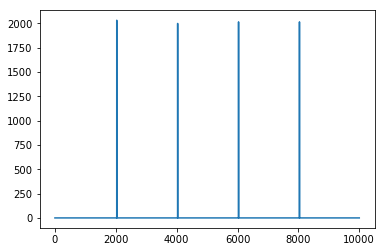

In [49]:
plt.plot(np.diff(ITI['EventIndex'])[:10000])

In [36]:
# checking the data and grabbing the indices
ITI_chunks = []

i = 0
counter = 0
while i < ITI.shape[0]-1:
    if ITI.iloc[[i]]['EventIndex'].values+1 == ITI.iloc[[i+1]]['EventIndex'].values:
        counter += 1
        i += 1
    else:
        ITI_chunks.append((i-counter, counter+1))
        counter = 0
        i += 1

#### example

In [37]:
ITI_chunks[0:5]

[(0, 2032), (2032, 2001), (4033, 2001), (6034, 2001), (8035, 2001)]

In [19]:
ITI_chunks[0]

(0, 2031)

In [11]:
ITI.iloc[[0]]

,EventData,EventIndex
19867,363,19867


In [14]:
ITI.iloc[[1]]

,EventData,EventIndex
19868,362,19868


In [15]:
ITI.iloc[[2030]]

,EventData,EventIndex
21897,365,21897


In [12]:
ITI.iloc[[2031]]

,EventData,EventIndex
21898,363,21898


In [13]:
ITI.iloc[[2032]]

,EventData,EventIndex
23931,365,23931


In [40]:
len(ITI_chunks)

160

### Stim chunks with counters

In [38]:
edges = [(650,750), (950,1050), (1300,1400), (1600,1700), (1950,2050), (2250,2350), (2600,2700), (2900,3000)]
# edges = [(650,750)]
stim_chunks = []
for i,edge in enumerate(edges):
    lower = edge[0]
    upper = edge[1]
    stim_data = df[(df['EventData'] >= lower) & (df['EventData'] <= upper)]
    counter = 0
    while i < stim_data.shape[0]-1:
        if stim_data.iloc[[i]]['EventIndex'].values+1 == stim_data.iloc[[i+1]]['EventIndex'].values:
            counter += 1
            i += 1
        else:
            stim_chunks.append((i-counter, counter+1))
            counter = 0
            i += 1

In [39]:
stim_chunks[0:5]

[(0, 1998), (1998, 2015), (4013, 1999), (6012, 1998), (8010, 1998)]

In [41]:
len(stim_chunks)

152

### Saving

In [57]:
# getting session data
session = 0
chan = np.arange(1,129).tolist()
# chan = [1]
data = asc.get_ECoG(data_path, session, chan)

# ITI blank data
ITIdata = np.vstack((data[0][ITI['EventIndex']], data[1][ITI['EventIndex']]))
for c in range(2,128):
    ITIdata = np.vstack((ITIdata, data[c][ITI['EventIndex']]))

In [ ]:
saveout_path = "../results/nt_vg/"
lfpca_files = sorted([f for f in os.listdir(saveout_path) if 'lfpca_' in f])
# fooof_files = sorted([f for f in os.listdir(saveout_path) if 'fooof' in f])

In [ ]:
vg_lfpca_objs = np.empty((9,),dtype=object)

In [ ]:
data[0][ITI['EventIndex']

In [ ]:
# blanks
ITI = df[(df['EventData'] > 300) & (df['EventData'] < 400)]

# different stimulations 1 to 8 according to the boundary edges
edges = [(650,750), (950,1050), (1300,1400), (1600,1700), (1950,2050), (2250,2350), (2600,2700), (2900,3000)]
stims = np.empty((8,),dtype=object)
for i,edge in enumerate(edges):
    lower = edge[0]
    upper = edge[1]
    stims[i]= df[(df['EventData'] > lower) & (df['EventData'] < upper)]
    
# getting session data
session = 0
chan = np.arange(1,129).tolist()
# chan = [1]
data = asc.get_ECoG(data_path, session, chan)

# ITI blank data
ITIdata = np.vstack((data[0][ITI['EventIndex']], data[1][ITI['EventIndex']]))
for c in range(2,128):
    ITIdata = np.vstack((ITIdata, data[c][ITI['EventIndex']]))

In [ ]:
# example of using LFPCA
fs = 1000
analysis_param = {'nperseg': 1000,
                  'noverlap': 0,
                  'spg_outlierpct': 2.,
                  'max_freq':200}

vg_lfpca = lfpca.LFPCA(analysis_param)
vg_lfpca.populate_ts_data(ITIdata, fs)
vg_lfpca_objs[8] = vg_lfpca